In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb

from matplotlib.colors import Colormap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from sklearn.metrics import rand_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.model_selection import train_test_split

In [5]:
dataset_red = pd.read_csv('../data/wine_quality/winequality-red.csv', delimiter=';')
dataset_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
dataset_red_train, dataset_red_test = train_test_split(dataset_red, test_size=0.2, stratify=dataset_red['quality'])
dataset_red_train_features = dataset_red_train.drop('quality', axis=1)
dataset_red_test_features = dataset_red_test.drop('quality', axis=1)
dataset_red_train_targets = dataset_red_train['quality']
dataset_red_test_targets = dataset_red_test['quality']


In [ ]:
def evaluate_internal(model, X, y):
    predictions = model.predict(X)
    silhouette = silhouette_score(X, predictions)
    davies_bouldin = davies_bouldin_score(X, predictions)
    print(f'Silhouette: {silhouette:.3f}')
    print(f'Davies Boulding: {davies_bouldin:.3f}')

def evaluate_external(model, X, y):
    predictions = model.predict(X)
    rand = rand_score(y, predictions)
    homogeneity = homogeneity_score(y, predictions)
    completeness = completeness_score(y, predictions)
    v_measure = v_measure_score(y, predictions)
    print(f'Rand Index: {rand:.3f}')
    print(f'Homogeneity: {homogeneity:.3f}')
    print(f'Completeness: {completeness:.3f}')
    print(f'V-measure: {v_measure:.3f}')



In [22]:
n_clusters = dataset_red_train_targets.value_counts().shape[0]

In [26]:
km1 = KMeans(n_clusters=n_clusters)
km1.fit(dataset_red_train_features)
evaluate_external(km1, dataset_red_train_features, dataset_red_train_targets)

Rand Index: 0.562
Homogeneity: 0.047
Completeness: 0.039
V-measure: 0.043


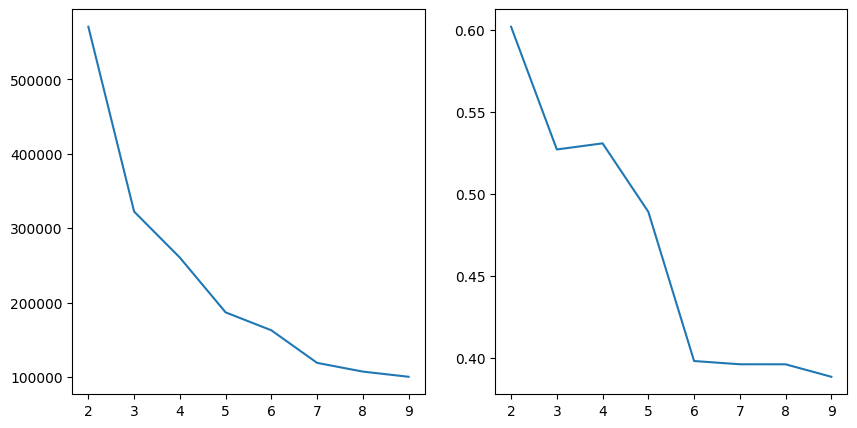

In [32]:
scores_inertia = []
scores_silhouette = []
n_clusters_to_test = range(2,10)
for n in n_clusters_to_test:
    km = KMeans(n_clusters=n).fit(dataset_red_train_features)
    scores_inertia.append(km.inertia_) 
    scores_silhouette.append(silhouette_score(dataset_red_train_features, km.predict(dataset_red_train_features))) 
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(n_clusters_to_test, scores_inertia)
ax[1].plot(n_clusters_to_test, scores_silhouette)


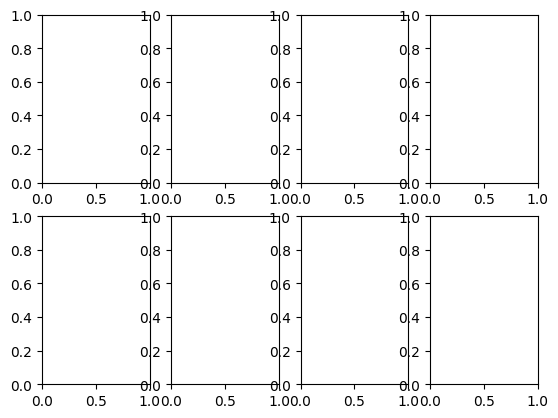

In [ ]:
fig, ax = plt.subplots(2,4)
n_clusters_to_test = range(2,10)
for n in n_clusters_to_test:
    km = KMeans(n_clusters=n).fit(dataset_red_train_features) 
    silhouette_average = silhouette_score(dataset_red_train_features, km.predict(dataset_red_train_features))
    silhouette_average = silhouette_samples(dataset_red_train_features, km.predict(dataset_red_train_features))
    x_start = 0
    for cluster_i in range(n):